# Powerplant Optimization with Differential Evolution

All information is taken from "Differential Evolution: A Survey of the State-of-the-Art"by Swagatam Das, Member, IEEE, and Ponnuthurai Nagaratnam Suganthan, Senior Member, IEEE.

In [41]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

We aim to optimize two parameters: the scaling factor (mutation) and the crossover probability. Moreover, we consider different instantiations.

Note that we consider the scaling factor $\in [0.4, 1]$. The reason for that is that finding an optimal solutions is difficult for a scaling factor greater than $1$ since we have "big steps". For a scaling factor smaller than $0.4$ these steps are considerably small and therefore increase the run time drastically .

## 1. Initialization 

Randomly initiated population of real-valued parameter vectors. Each vector, called chromosome, forms a candidate solution to the multidimensional optimization problem.

In [42]:
def initialize(population_size_NP,p1,p2,p3,d1,d2,d3):
    # randomly initialize a population of NP individuals within the domain
    population = []
    random_chromosome = []
    for i in range(population_size_NP):
        random_chromosome = []
        # initialize energy produced:
        random_chromosome.append(random.uniform(0,5000000))
        random_chromosome.append(random.uniform(0,30000000))
        random_chromosome.append(random.uniform(0,12000000))
        
        # initialize demands
        random_chromosome.append(random.uniform(0,d1))
        random_chromosome.append(random.uniform(0,d2))
        random_chromosome.append(random.uniform(0,d3))
        
        # initialize prices
        random_chromosome.append(random.uniform(0,p1))
        random_chromosome.append(random.uniform(0,p2))
        random_chromosome.append(random.uniform(0,p3))
        
        population.append(random_chromosome)
    
    return population

## 2. Mutation

In [43]:
def feasible_vector(donor_vector,p1,p2,p3,d1,d2,d3):
    feasible = True
    if (donor_vector[0] < 0) or (donor_vector[0] > 5000000):
        feasible = False
    elif (donor_vector[1] < 0) or (donor_vector[1] > 30000000):
        feasible = False
    elif (donor_vector[2] < 0) or (donor_vector[2] > 12000000):
        feasible = False
    elif (donor_vector[3] < 0) or (donor_vector[3] > d1):
        feasible = False
    elif (donor_vector[4] < 0) or (donor_vector[4] > d2):
        feasible = False
    elif (donor_vector[5] < 0) or (donor_vector[5] > d3):
        feasible = False
    elif (donor_vector[6] < 0) or (donor_vector[6] > p1):
        feasible = False
    elif (donor_vector[7] < 0) or (donor_vector[7] > p2):
        feasible = False
    elif (donor_vector[8] < 0) or (donor_vector[8] > p3):
        feasible = False
        
    return feasible

In [44]:
def mutate(target_vector_X,scale_factor_F,population,p1,p2,p3,d1,d2,d3):
    population_size = len(population)
    finished = False
    while not finished:
        param_vectors = []
        vectors_used = 0
        while vectors_used < 3:
            rand = random.randint(0, population_size-1)
            new_vector = population[rand]

            # check if new_vector is not the target_vector_X and not already chosen for param_vectors
            # (new_vector!=param_vectors).all() or this one //// if-statement not working
            if not np.array_equiv(new_vector,target_vector_X):
                if vectors_used == 0:
                    param_vectors.append(new_vector)
                    vectors_used += 1
                else:
                    for i in range(vectors_used):
                        if not np.array_equiv(new_vector, param_vectors[i]):
                                param_vectors.append(new_vector)
                                vectors_used += 1
                                break
        
        donor_vector_V = param_vectors[0] + scale_factor_F*(param_vectors[1]-param_vectors[2])
        if feasible_vector(donor_vector_V,p1,p2,p3,d1,d2,d3):
            finished = True
    
    return donor_vector_V

## 3. Crossover / Recombination

In [45]:
def crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr):
    trial_vector_U = np.copy(target_vector_X)
    D = len(target_vector_X)
    for j in range(D):
        j_rand = random.randint(1,D)
        if (random.random() <= cross_over_rate_Cr) or j == j_rand :
            trial_vector_U[j] = donor_vector_V[j]
        else:
            trial_vector_U[j] = target_vector_X[j]
    return trial_vector_U

## 4. Selection

In [46]:
def demand(price, maxPrice, maxDemand):
    if(price > maxPrice):
        return 0
    
    if(price <= 0):
        return maxDemand
    
    demand = maxDemand - price**2 * maxDemand / maxPrice**2
    
    return demand

In [47]:
def cost(x, kwhPerPlant, costPerPlant, maxPlants):
    if(x <= 0):
        return 0
    
    if(x > kwhPerPlant * maxPlants):
        return float("Inf")
    
    plantsNeeded = math.ceil(x / kwhPerPlant)
    
    return plantsNeeded * costPerPlant

In [48]:
def objective(tested_vector,cost_price,p1,p2,p3,d1,d2,d3):
    
    # each e already provides the sum of energy produced per plant type
    total_energy_produced = tested_vector[0] + tested_vector[1] + tested_vector[2]
    
    total_energy_planned =  tested_vector[3] + tested_vector[4] + tested_vector[5]
    
    purchasing_cost = max((total_energy_planned-total_energy_produced),0)*cost_price
    
    production_cost = cost(tested_vector[0], 50000, 10000, 100) + cost(tested_vector[1], 600000, 80000, 50) + cost(tested_vector[2], 4000000, 400000, 3)
    
    total_cost = purchasing_cost + production_cost
    
    revenue = min(demand(tested_vector[6], p1, d1), tested_vector[3])*tested_vector[6] + min(demand(tested_vector[7], p2, d2), tested_vector[4])*tested_vector[7] + min(demand(tested_vector[8], p3, d3), tested_vector[5])*tested_vector[8]
    
    #profit equals fitness
    profit = revenue - total_cost
    
    return profit

In [49]:
def select(target_vector_X,trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3):
    # Evaluate the trial vector and choose new target vector with better value

    if objective(target_vector_X,cost_price,p1,p2,p3,d1,d2,d3) > objective(trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3):
        new_target_vector = target_vector_X
    else:
        new_target_vector = trial_vector_U

    return new_target_vector

## 5. Action

In [50]:
def get_best(new_population,population_size_NP):
    #choose the best one of the final population
    best_chromosome = new_population[0]
    for i in range(population_size_NP):
        if objective(new_population[i],cost_price,p1,p2,p3,d1,d2,d3) > objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3):
            best_chromosome = new_population[i]

    return best_chromosome

In [51]:
# set factors:
scale_factor_F = 0.6
cross_over_rate_Cr = 0.9
population_size_NP = 30
cost_price = 0.6

# market prices
p1 = 0.45
p2 = 0.25
p3 = 0.2

# market demands
d1 = 2000000
d2 = 30000000
d3 = 20000000

# Initialization:
generation_number_G = 0
new_population = initialize(population_size_NP,p1,p2,p3,d1,d2,d3)
best_solution_list = []

converged = False
while not converged:
    population = np.copy(new_population)
    for i in range(population_size_NP):
        target_vector_X = population[i]
        
        # Mutation:
        donor_vector_V = mutate(target_vector_X,scale_factor_F,population,p1,p2,p3,d1,d2,d3)
        #print("feasible1 ",feasible_vector(donor_vector_V,p1,p2,p3,d1,d2,d3))
        
        # Crossover:
        trial_vector_U = crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr)
        #print("feasible2 ",feasible_vector(trial_vector_U,p1,p2,p3,d1,d2,d3))
        
        # Selection:
        new_population[i] = select(target_vector_X,trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3)
        #print("feasible3 ",feasible_vector(new_population[i],p1,p2,p3,d1,d2,d3))
    
    generation_number_G += 1
    converged = (generation_number_G == 1000)
    #choose the best one of the final population
    best_chromosome = get_best(new_population,population_size_NP)
    best_solution_list.append(objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3))
    
print("done!")
print("best Chromosome:")
print(best_chromosome)
print(objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3))

done!
best Chromosome:
[  4.99999854e+04   5.99999997e+06   1.19999997e+07   1.05503416e+06
   1.13561752e+07   5.63879008e+06   3.09318452e-01   1.97081942e-01
   1.69476889e-01]
1510082.858


## 6. Plot

In [52]:
def simple_plot(best_profit_per_run,minimum_solution,best_solution,scale_factor_F_plot,cross_over_rate_Cr_plot,population_size_NP_plot,cost_price_plot):
    fig, ax = plt.subplots(figsize=plt.figaspect(0.2))
    ax.plot(best_profit_per_run, ':r', label=f"F: {scale_factor_F_plot}\nCr: {cross_over_rate_Cr_plot}\npopulation size: {population_size_NP_plot}\ncost price: {cost_price_plot}")
    ax.set(ylim=[minimum_solution,best_solution],ylabel='Profit', xlabel='Iteration', title='DE on Power Plant Optimization')
    ax.legend()
    plt.show()
    fig.savefig(f"plots/F{scale_factor_F_plot}_Cr{cross_over_rate_Cr_plot}_PopSize{population_size_NP_plot}_CostPrice{cost_price_plot}.png")

Best solution in this run:  1510082.858


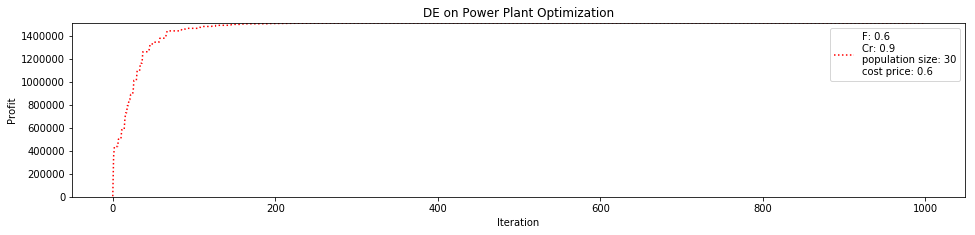

In [53]:
best_profit_per_run = best_solution_list
best_solution = max(best_solution_list)
scale_factor_F_plot = scale_factor_F
cross_over_rate_Cr_plot = cross_over_rate_Cr
population_size_NP_plot = population_size_NP
cost_price_plot = cost_price

print("Best solution in this run: ",best_solution)
simple_plot(best_profit_per_run,0,best_solution,scale_factor_F_plot,cross_over_rate_Cr_plot,population_size_NP_plot,cost_price_plot)